## Define some helper functions to process the `csv` data

In [18]:
import glob,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simps,cumtrapz
from scipy.interpolate import interp1d

kB=8.617e-5

# Helper functions
class ProcessPAFI:
    def __init__(self, csv_file, validity_fn = lambda x : x['MaxJump']<0.4) :
        """
            Take a PAFI csv data dump and produce ensemble average and standard deviation
            `data` : pandas DataFrame in PAFI format
            `validity_criteria` : a function acting on a Dataframe which returns valid data
        """
        if not os.path.exists(csv_file):
            print("csv file {} caould not be found!".format(csv_file))
            return
        self.all_data = pd.read_csv(csv_file)
        self.nWorkers = max(set(self.all_data['WorkerID'])) + 1
        self.validity_fn = validity_fn
        self.validate()
        self.ensemble_average()
    
    def validate(self):
        self.valid = np.ones(self.all_data.shape[0],bool)
        self.nValid = self.valid.sum()
        if not self.validity_fn is None:
             self.valid = self.validity_fn(self.all_data)
        
    def ensemble_average(self):
        
        data = self.all_data[self.valid]


        # Every field before nWorkers is a parameter
        self.nParams = np.where(data.columns=='WorkerID')[0][0]
        self.param_names = list(data.columns[:self.nParams])
        self.field_names = list(data.columns[self.nParams+1:])
        
        raw_data = data.drop('WorkerID', axis=1).to_numpy()
        # parameters
        self.param_data = pd.DataFrame(data = raw_data[:,:self.nParams],
                                       columns = self.param_names).drop_duplicates()
        # ensemble
        ens_columns = self.param_names + self.field_names + [f+"_std" for f in self.field_names]
        ens_data = []        
        for p in self.param_data.to_numpy():
            sel = (raw_data[:,:self.nParams] == p).min(axis=1)
            ens_data += [list(raw_data[sel].mean(axis=0)) + list(raw_data[sel].std(axis=0)[self.nParams:])]
        self.ens_data = pd.DataFrame(data = np.r_[ens_data], columns = ens_columns)
    
    # splined rediscretization, first column is coordinate
    def remesh(self,data,density = 10):
        spl_data = np.zeros((density*data.shape[0],data.shape[1]))
        spl_data[:,0] = np.linspace(data[:,0][0],data[:,0][-1],spl_data.shape[0])
        for ii in range(1,data.shape[1]):
            spl_data[:,ii] = interp1d(data[:,0], data[:,ii],kind='cubic')(spl_data[:,0])
        return spl_data\
    
    
    def integrate(self,x='ReactionCoordinate',y='aveF',remesh=10):
        param_data = self.param_data.drop(x,axis=1).drop_duplicates()
        param_fields = list(param_data.columns) + [x,y+"_int",y+'_int_std']
        all_data = []
        for p in param_data.iterrows():
            ee = self.ens_data.copy()
            for key,val in p[1].items():
                ee = ee[ee[key]==val]
            data = np.r_[[ee[w].to_numpy() for w in [x,y,y+"_std"]]].T
            data = self.remesh(data[data[:,0].argsort(),:],remesh)
            y_a = np.append(np.zeros(1),cumtrapz(data[:,1],data[:,0]))
            y_e = np.append(np.zeros(1),cumtrapz(data[:,2],data[:,0]))
            
            all_data += [[*list(p[1].to_dict().values()),data[:,0],y_a,y_e]]
        return pd.DataFrame(data=all_data,columns=param_fields)
        
def plot_df(ax,df,index=0,x='ReactionCoordinate',y='aveF_int',min_shift=True,ls='o-'):
    
    r_Fave_Fstd = np.r_[[df[x].to_numpy()[0],df[y].to_numpy()[0],df[y+"_std"].to_numpy()[0]]].T
    
    if min_shift:
        
        run_min =  np.minimum.accumulate(r_Fave_Fstd[:,1])
        run_min_shift =  np.minimum.accumulate(np.append(r_Fave_Fstd[1:,1],r_Fave_Fstd[-1][1]))
        argmax = r_Fave_Fstd[:,1].argmax()
        if (run_min == run_min_shift).sum()>0 and run_min[argmax] == run_min_shift[argmax]:
            r_Fave_Fstd = r_Fave_Fstd[run_min == run_min_shift,:]
        r_Fave_Fstd[:,1] -= r_Fave_Fstd[0][1]
        
    barrier = r_Fave_Fstd[:,1].max()
    error = r_Fave_Fstd[0][2] + r_Fave_Fstd[r_Fave_Fstd[:,1].argmax()][2]
    
    ax.plot(r_Fave_Fstd[:,0],
                r_Fave_Fstd[:,1],
                'C%d%s' % (index,ls),label='%dK' % T[i_f])

    ax.fill_between(r_Fave_Fstd[:,0],
            r_Fave_Fstd[:,1]-r_Fave_Fstd[:,2],
            r_Fave_Fstd[:,1]+r_Fave_Fstd[:,2],
            facecolor='0.8')
    
    return barrier,error

# Standard PAFI force integration

It is clear in this test example we have not accumulated enough sampling data

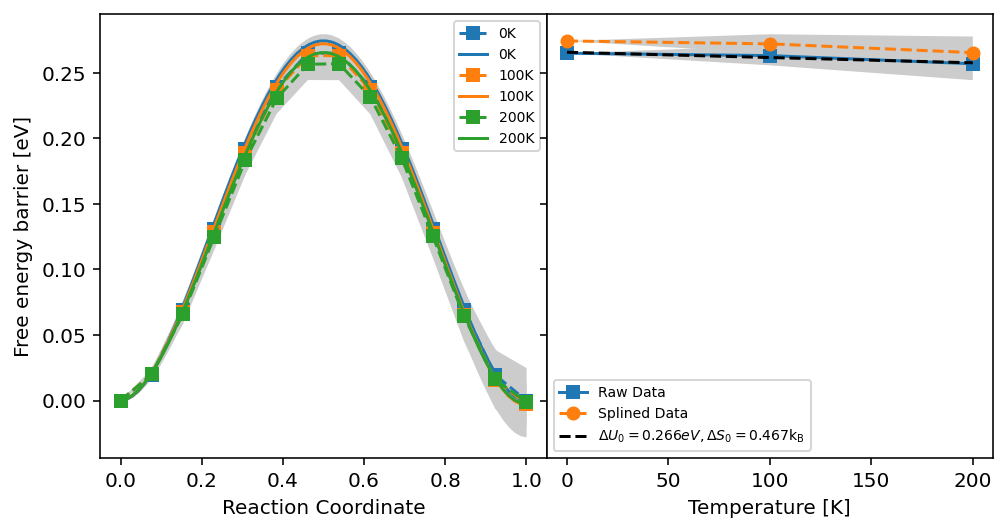

In [19]:
PS = ProcessPAFI('dumps/raw_data_output_0.csv')

r_F_data = PS.integrate(x='ReactionCoordinate',y='aveF',remesh=2)

r_F_data_dense = PS.integrate(x='ReactionCoordinate',y='aveF',remesh=10)

T = np.unique(r_F_data["Temperature"])

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=144,sharey=True);

bar = []
for ii,i_f in enumerate(T.argsort()):
    data = r_F_data[r_F_data["Temperature"]==T[i_f]]
    barrier,error = plot_df(axs[0],data,index=ii,ls='s--')
    
    dense_data = r_F_data_dense[r_F_data_dense["Temperature"]==T[i_f]]
    dense_barrier,dense_error = plot_df(axs[0],dense_data,index=ii,ls='-')
    
    bar += [[T[i_f],barrier,error,dense_barrier,dense_error]]

bar = np.r_[bar]
p = np.polyfit(bar[:,0],bar[:,1],1)
axs[1].plot(bar[:,0],bar[:,1],'s-',label='Raw Data')
axs[1].plot(bar[:,0],bar[:,3],'o--',label='Splined Data')

axs[1].plot(bar[:,0],p[1]+p[0]*bar[:,0],'k--',label=r'$\Delta U_0=%2.3geV,\Delta S_0=%2.3g{\rm k_B}$' % (p[1],-p[0]/kB))
axs[1].fill_between(bar[:,0],bar[:,1]-bar[:,2],bar[:,1]+bar[:,2],facecolor='0.8')
axs[1].fill_between(bar[:,0],bar[:,3]-bar[:,4],bar[:,3]+bar[:,4],facecolor='0.8')

axs[0].legend(fontsize=7)
axs[1].legend(fontsize=7)
axs[0].set_xlabel("Reaction Coordinate")
axs[1].set_xlabel("Temperature [K]")
axs[0].set_ylabel("Free energy barrier [eV]")
plt.subplots_adjust(wspace=0) 
